In [1]:
import numpy as np
import torch
import torch.nn.functional as F
import cv2
import matplotlib.pyplot as plt

from utils.utils import gravity_align, gravity_align_depth, gravity_align_normal
from src.depth_aggregation import *

#### Load other data

In [2]:
# t = 0
#euler_angles = np.array([-2.05386654, 0.05212421, -1.59732346]).astype(np.float32)

# t = 90
#euler_angles = np.array([-1.77211733, 0.01404211, 0.13990366]).astype(np.float32)

# t=120
#euler_angles = np.array([-1.78765814, -0.00908211, 1.51359217]).astype(np.float32)

# t=171
#euler_angles = np.array([-1.78766129, 0.04809726, 0.21039819]).astype(np.float32)

# t=173
euler_angles = np.array([-1.78497668, 0.03515128, 0.15020113]).astype(np.float32)

# t=334 / ios_2022-07-01_15.45.08_000
#euler_angles = np.array([-1.80686384, 0.03246141, -0.73058705]).astype(np.float32)

# t=342 / ios_2022-07-01_15.45.08_000
#euler_angles = np.array([-1.86258108, 0.04842507, -1.74592793]).astype(np.float32)

In [3]:
# t = 0
#gt_depth = np.array([9.19942243, 9.42790381, 9.65638519, 9.87298438, 10.07515579, 10.27732719, 10.56382740, 10.85543976, 11.20006808, 11.60276736, 12.03167997, 12.94375971, 13.85583944, 17.43644585, 22.37775872, 25.71889230, 25.44295466, 25.16701702, 24.88749596, 24.60790860, 24.32599123, 24.04300196, 23.78871296, 23.57516263, 23.35321862, 23.08864843, 22.82407824, 22.85704054, 22.91031896, 22.92785460, 22.93187740, 22.93589751, 22.93991524, 22.94393118, 22.94794377, 22.95195542, 22.95596281, 22.95997009, 22.96397221, 22.96797434, 22.97197186, 22.97596868, 22.97996166, 22.98395314, 22.98794155, 22.99192766, 22.99591147, 22.99989221, 23.00387143, 23.00784679, 23.01182143, 23.01579142, 23.01976141, 23.02372616, 23.02769080, 23.03165109, 23.03561042, 23.03956631, 23.04352036, 23.04747196, 23.05142079, 22.12389660, 18.73253476, 15.51409776, 14.82817052, 14.14224329, 13.54255830, 12.95985557, 12.45115652, 11.99459284, 11.55456313, 11.15047371, 10.74732501, 10.39501728, 10.04270956, 9.74188995, 9.46384850, 9.19482373, 8.94348187, 8.69214000, 8.46571243, 8.24063654, 8.02903120, 7.82972380, 7.63185728, 7.45775929, 7.28366130, 7.12304854, 6.97354173, 6.82403491])

# t = 90
#gt_depth = np.array([2.13465063, 2.17735281, 2.22005499, 2.24181579, 2.23814883, 2.23448187, 2.23084225, 2.22720429, 2.24653144, 2.29101339, 2.33551527, 2.38038455, 2.42525384, 2.48662785, 2.55641778, 2.61873627, 2.66416624, 2.70959620, 3.12368980, 3.54460484, 3.74226048, 3.83720787, 3.94277824, 4.06342746, 4.18412576, 4.30507338, 4.42602100, 4.57113192, 4.71789276, 4.86471161, 5.01155238, 5.18575232, 5.38412010, 5.59142966, 5.81536076, 6.04385176, 6.29312136, 6.54037298, 6.68538266, 6.83039234, 6.99725104, 7.16749371, 8.02168091, 9.14514582, 10.76489143, 12.75572941, 13.88569788, 13.86438175, 14.21043331, 15.48957035, 16.60397028, 16.65472179, 16.70547330, 18.75622581, 20.84645319, 22.77458753, 24.66715031, 28.39836647, 33.11871006, 35.41565171, 34.96918685, 34.52429313, 34.08355524, 33.40832232, 29.29887532, 25.18942831, 23.13515316, 21.48556903, 19.73835199, 17.92235286, 16.59280166, 16.32065399, 16.05301936, 16.02929191, 16.00556447, 16.09034851, 16.22313765, 16.30299430, 16.27904331, 16.25509232, 16.39473059, 16.54324409, 14.51397265, 10.49648962, 6.70114039, 6.57005046, 6.43896054, 6.32209642, 6.21694816, 6.11179989])

# t=120
#gt_depth = np.array([8.38663424, 6.63004464, 4.87345503, 3.87854327, 3.80848790, 3.73843252, 3.74363177, 3.75339308, 3.75936214, 3.76117738, 3.76243479, 3.75341056, 3.74438632, 3.74982818, 3.76264643, 3.77209265, 3.77391669, 3.77574074, 3.77756754, 3.77939439, 3.81382193, 3.86324710, 3.90296953, 3.92891940, 3.95091488, 3.95282848, 3.95474209, 14.79728158, 26.38004077, 32.26074940, 35.98575342, 38.90688667, 41.11791661, 45.65004261, 54.49677057, 59.08040102, 44.23788872, 30.00635911, 46.73037291, 63.45438671, 59.08173092, 51.44163816, 49.31881667, 49.36821543, 51.73796833, 55.84275889, 54.20743286, 44.89555686, 37.13850166, 33.33057093, 30.02502495, 29.96319722, 29.90136949, 33.75318896, 37.68225374, 36.92237136, 35.13349218, 33.21172101, 31.21845888, 30.13166452, 30.07103488, 29.49026381, 27.53366755, 26.06085027, 31.67304684, 37.28524341, 31.98114916, 24.52749019, 23.87778003, 28.02143005, 30.71861001, 30.27156325, 29.73386956, 24.29716973, 18.86046989, 19.74815810, 23.43373283, 25.84749502, 25.76706340, 25.68663178, 24.64986087, 23.56120554, 20.92092789, 16.86409461, 13.03695943, 12.99886203, 12.96076463, 14.58965002, 17.59140139, 20.59315276])

# t=171
#gt_depth = np.array([4.85695660, 4.89318162, 4.92940664, 5.40851753, 6.42539622, 7.44227491, 7.59968697, 7.70499667, 7.83456264, 7.99069767, 8.14557458, 8.27726161, 8.40894864, 8.49041106, 8.54626349, 8.55497589, 8.45713223, 8.35928858, 8.38847884, 8.42001962, 8.48731830, 8.57106705, 8.65487458, 8.73876554, 8.81835297, 8.87608545, 8.93381792, 8.99157776, 9.04933947, 9.10707317, 9.16479629, 9.23646390, 9.32044945, 9.39510338, 9.45241114, 9.51441790, 9.59783720, 9.68073789, 9.73736284, 9.79398779, 9.85028686, 9.90653547, 9.98122876, 10.06318396, 10.12981186, 10.18497881, 10.26205864, 10.36844366, 10.46721580, 10.54665180, 10.62595224, 10.70437739, 10.78280255, 10.88500755, 10.98768190, 11.08910429, 11.19025195, 11.27417604, 11.34883449, 11.43440227, 11.53231992, 11.62307279, 11.69487411, 11.76964687, 11.88793691, 12.00622695, 12.12247107, 12.23831232, 12.35265697, 12.46594726, 12.58562741, 12.71919733, 12.85229883, 12.96008470, 13.06787057, 13.15834759, 13.24116724, 15.08307666, 20.37479549, 25.66651432, 25.66503251, 25.37637789, 25.09123034, 24.80928456, 24.52889329, 24.27414481, 24.01939633, 23.77904509, 23.55055090, 23.32205670])

# t=173
gt_depth = np.array([7.40051609, 7.31771659, 7.23491709, 7.19446063, 7.20541860, 7.21637657, 7.22763029, 7.23890193, 7.28493043, 7.36902980, 7.45316888, 7.53803974, 7.62291060, 7.69188348, 7.75274983, 7.81376394, 7.87511205, 7.93646015, 7.97354963, 8.01019025, 8.06434819, 8.12656479, 8.18889930, 8.25140115, 8.31393888, 8.37665879, 8.43937870, 8.50223911, 8.56510912, 8.62803828, 8.69098980, 8.75394794, 8.81691193, 8.87985599, 8.94276303, 9.00564729, 9.06842777, 9.13170609, 9.22020757, 9.30870905, 9.37445881, 9.43668481, 9.51720470, 9.60492713, 9.69232129, 9.77946998, 9.86633427, 9.95281819, 10.04629893, 10.15755105, 10.26185226, 10.32127398, 10.38069569, 10.48888663, 10.59804014, 10.68561983, 10.76846510, 10.86671040, 10.97324035, 11.09057459, 11.22013978, 11.33584028, 11.41486726, 11.49687696, 11.62256893, 11.74826089, 11.89191923, 12.03911539, 12.17099961, 12.29209661, 12.39791262, 12.47051197, 12.63990246, 18.04036187, 23.44082128, 24.91227527, 24.64555138, 24.38344273, 24.13038515, 23.87732758, 23.63454006, 23.39230973, 23.15262806, 22.91527320, 22.67897951, 22.46019070, 22.24140189, 18.75256210, 12.57062808, 6.38869405])

# t=334
#gt_depth = np.array([1.82054270, 1.83228797, 1.84403324, 1.85595441, 1.86808918, 1.88022394, 1.89273748, 1.90527398, 1.91800844, 1.93095974, 1.94393310, 1.95731315, 1.97069319, 1.98436707, 1.99819077, 2.01215544, 2.02643876, 2.04072208, 2.05547346, 2.07023350, 2.08533262, 2.10058773, 2.11605561, 2.13182550, 2.14768356, 2.16398944, 2.18029531, 2.19712429, 2.21398899, 2.23127709, 2.24872526, 2.26649738, 2.28455566, 2.30283744, 2.32153465, 2.34035248, 2.35971989, 2.37910093, 2.39917250, 2.41924407, 2.43995737, 2.46077006, 2.48214344, 2.50373757, 2.52580402, 2.54822366, 2.57101713, 2.59431056, 2.61786580, 2.64208604, 2.66643840, 2.69164383, 2.71684926, 2.74308403, 2.76933912, 2.79651349, 2.82388960, 2.85204615, 2.88062254, 2.90980333, 2.93966833, 2.96991394, 3.00116629, 3.03251440, 3.06526492, 3.09801545, 3.13212198, 3.16649553, 3.20190416, 3.23804200, 3.27478633, 3.31284902, 3.35095001, 3.39112092, 3.43129183, 3.47307031, 3.51555997, 3.55891479, 3.60396630, 3.64901780, 3.69676718, 3.74466292, 3.79421815, 3.84528840, 3.89656234, 3.95119618, 4.00583001, 4.06267137, 4.12133078, 4.17999018])

# t=342
#gt_depth = np.array([20.84323437, 20.87641195, 20.90958952, 21.63400151, 23.19773496, 24.76146841, 21.58210174, 18.11520005, 16.28453173, 16.24610944, 16.21440405, 16.30650524, 16.39860643, 14.77329580, 12.27226098, 10.49473325, 10.35263268, 10.21053211, 10.17893165, 10.14937578, 10.15144498, 10.16806297, 10.18473058, 10.20146861, 10.22615253, 10.29118864, 10.35622476, 10.49052252, 10.62954960, 25.55594789, 46.07282699, 47.52790973, 32.14465878, 21.32111847, 18.97346018, 17.03977567, 16.99249271, 16.94667742, 16.97522231, 17.00376719, 22.42527345, 28.68203769, 29.11886616, 27.26431151, 25.40148741, 23.53247986, 21.68020144, 19.85029574, 18.39936313, 17.91099283, 17.48167300, 17.43362085, 17.38556870, 17.49070158, 17.59885794, 21.23064480, 25.63569790, 27.12271624, 27.03993994, 26.19072270, 24.47385777, 23.19659584, 23.08212703, 22.39662855, 13.34831704, 4.30000554, 2.75133820, 2.67945182, 2.62261854, 2.57639010, 2.52225466, 2.45093159, 2.38007012, 2.33415542, 2.28824073, 2.25974845, 2.23896377, 2.22655017, 2.23055337, 2.23455656, 2.23859210, 2.24262939, 2.23410565, 2.21411430, 2.19277842, 2.14926359, 2.10574875, 2.08819053, 2.09200923, 2.09582793])


#### Load normal image

In [4]:
# Load normal
pred_normal_save_path = "/cluster/home/wueestm/f3loc/metric3d/data/hge_customized_complete/non-aligned/normal_arr/ViT-Large/00173-0_normal_arr.npy"
pred_normal = np.load(pred_normal_save_path, allow_pickle=True)
pred_normal.shape

(1920, 1440, 3)

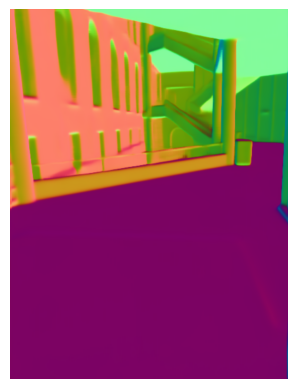

In [5]:
pred_normal_vis = (pred_normal + 1) / 2
# Plot the image
plt.imshow((pred_normal_vis*255).astype(np.uint8))
plt.axis('off')  # Turn off axis labels and ticks
plt.show()

In [6]:
pred_normal[960, 720]

array([-0.02970794, -0.9741323 , -0.22401716], dtype=float32)

#### Load depth image

In [7]:
# Load pred depth
pred_depth_save_path = "/cluster/home/wueestm/f3loc/metric3d/data/hge_customized_complete/non-aligned/pred_depth/ViT-Large/00173-0_pred_depth.npy"
pred_depth = np.load(pred_depth_save_path, allow_pickle=True)
pred_depth.shape

(1920, 1440)

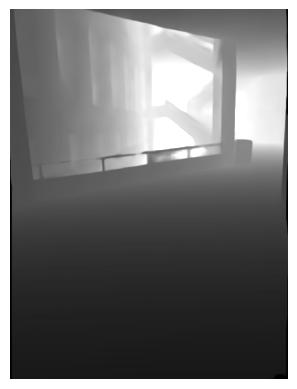

In [8]:
# Plot the image
plt.imshow(pred_depth)
plt.axis('off')  # Turn off axis labels and ticks
plt.imshow(pred_depth, cmap='gray', vmin=0, vmax=20)

#### Align normal image to gravity

In [9]:
K = np.array([[1596, 0, 960], [0, 1596, 720], [0, 0, 1]])
r=euler_angles[1]
p=-(euler_angles[0]+np.pi/2)
#pred_normal_aligned = gravity_align_normal(pred_normal, r, p, K=K)
pred_normal_aligned = gravity_align_normal(pred_normal, pred_depth, r, p, K=K)

In [10]:
pred_normal.shape

(1920, 1440, 3)

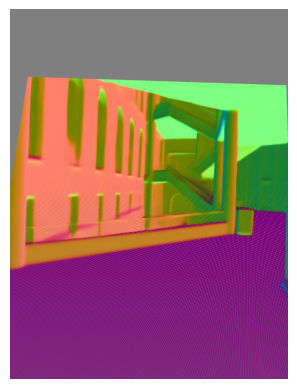

In [11]:
pred_normal_vis = (pred_normal_aligned + 1) / 2
# Plot the image
plt.imshow((pred_normal_vis*255).astype(np.uint8))
plt.axis('off')  # Turn off axis labels and ticks
plt.show()

#### Align depth image to gravity

In [12]:
K = np.array([[1596, 0, 960], [0, 1596, 720], [0, 0, 1]])
r=euler_angles[1]
p=-(euler_angles[0]+np.pi/2)
pred_depth_aligned,_ = gravity_align_depth(pred_depth, r, p, K=K)

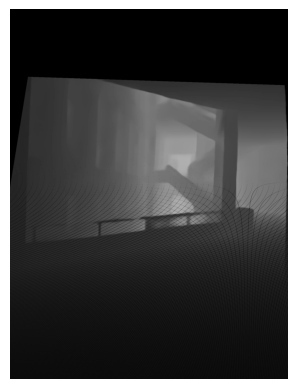

In [13]:
# Plot the image
plt.axis('off')  # Turn off axis labels and ticks
plt.imshow(pred_depth_aligned, cmap='gray', vmin=0, vmax=40)

#### Extract normal mask

In [14]:
threshold_angle_cos = 0.98  # Cosine of threshold angle (e.g., cos(18°) ≈ 0.95)

In [15]:
# Step 1: Identify Horizontal Planes
vertical_vector_ground = np.array([0, -1, 0])  # Assuming y-axis is vertical
# Compute the dot product between normals and the vertical vector
dot_products_ground = np.dot(pred_normal_aligned, vertical_vector_ground)
# Identify planes that are nearly horizontal
horizontal_planes_ground_mask = dot_products_ground > threshold_angle_cos

In [16]:
# Step 1: Identify Horizontal Planes
vertical_vector_ceiling = np.array([0, 1, 0])  # Assuming y-axis is vertical
# Compute the dot product between normals and the vertical vector
dot_products_ceiling = np.dot(pred_normal_aligned, vertical_vector_ceiling)
# Identify planes that are nearly horizontal
horizontal_planes_ceiling_mask = dot_products_ceiling > threshold_angle_cos

In [17]:
# Step 2: Apply Mask to RGB Image
masked_pred_normal_vis = pred_normal_vis.copy()
masked_pred_normal_vis[horizontal_planes_ground_mask] = [0, 0, 0]  # Mask out the horizontal planes
masked_pred_normal_vis[horizontal_planes_ceiling_mask] = [0, 0, 0]  # Mask out the horizontal planes

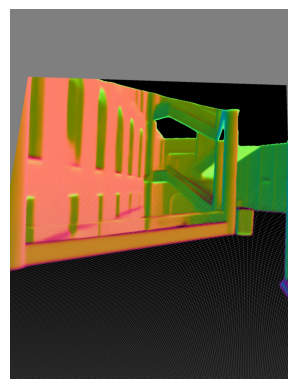

In [18]:
# Plot the image
plt.imshow((masked_pred_normal_vis*255).astype(np.uint8))
plt.axis('off')  # Turn off axis labels and ticks
plt.show()

#### Apply normal mask on gravity-aligned depth image

In [19]:
pred_depth_aligned_masked = pred_depth_aligned
pred_depth_aligned_masked[horizontal_planes_ground_mask] = 0
pred_depth_aligned_masked[horizontal_planes_ceiling_mask] = 0

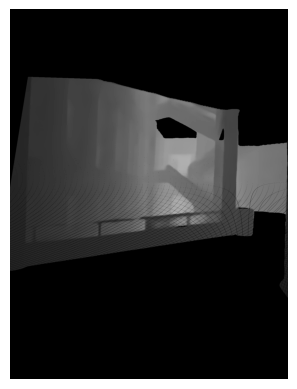

In [20]:
# Plot the image
plt.axis('off')  # Turn off axis labels and ticks
plt.imshow(pred_depth_aligned_masked, cmap='gray', vmin=0, vmax=40)

#### Aggregate depth

downsampled_percentiles shape:  (90,)
downsampled_percentiles shape:  (90,)
downsampled_percentiles shape:  (90,)
downsampled_percentiles shape:  (90,)
downsampled_percentiles shape:  (90,)
downsampled_percentiles shape:  (90,)
downsampled_percentiles shape:  (90,)


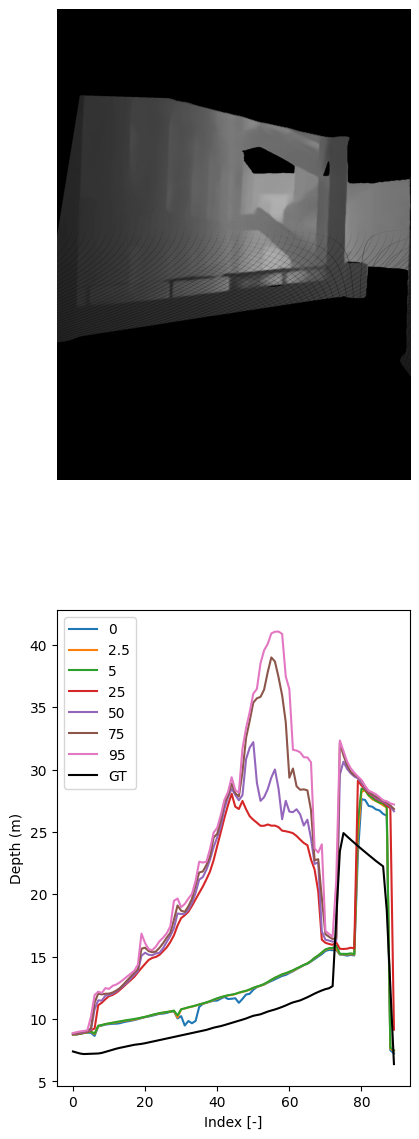

In [23]:

fontsize = 10
fig, axs = plt.subplots(2, 1, figsize=(4, 3.4*4), gridspec_kw={'height_ratios': [2,1]})



axs[0].imshow(pred_depth_aligned_masked, cmap='gray', vmin=0, vmax=40)
axs[0].axis('off')  # Turn off axis labels and ticks






correction_factor = 1.5
p_ls = [0, 2.5, 5, 25, 50, 75, 95]
pred_depth_aggregated_ls = []
for p in p_ls:
    pred_depth_aggregated = correction_factor*get_column_percentile_and_downsample(pred_depth_aligned_masked, p=p)
    axs[1].plot(pred_depth_aggregated, label=str(p))
axs[1].plot(gt_depth, color="k", label="GT")
axs[1].legend(fontsize = fontsize)
axs[1].set_xlabel("Index [-]", fontsize = fontsize)
axs[1].set_ylabel("Depth (m)", fontsize = fontsize)

# Set tight layout to adjust spacing between subplots
plt.tight_layout(pad=0.00)
#fig.subplots_adjust(hspace=0.0)  # Decrease hspace to reduce vertical spacing

# Show the plot
plt.show()

In [ ]:
correction_factor = 1.5
p_ls = [5, 25, 50, 75, 95]
pred_depth_aggregated_ls = []

for p in p_ls:
    pred_depth_aggregated = correction_factor*get_column_percentile_and_downsample(pred_depth_aligned_masked, p=p)
    plt.plot(pred_depth_aggregated, label=str(p))
plt.plot(gt_depth, color="k", label="GT")
plt.legend()
plt.xlabel("Index [-]")
plt.ylabel("Depth (m)")
plt.show()

#### Parking Lot

In [ ]:
import numpy as np

def gravity_align_normal(normals_img, r, p):
    """
    Align the normals image with gravity direction
    Input:
        normals_img: input normals image (HxWx3)
        r: roll
        p: pitch
    Output:
        aligned_normals_img: gravity-aligned normals image
    """
    # Calculate R_gc from roll and pitch
    p = -p  # Adjust pitch as before
    cr = np.cos(r)
    sr = np.sin(r)
    cp = np.cos(p)
    sp = np.sin(p)

    # Compute R_cg first
    # Pitch
    R_x = np.array([[1, 0, 0], [0, cp, sp], [0, -sp, cp]])

    # Roll
    R_z = np.array([[cr, sr, 0], [-sr, cr, 0], [0, 0, 1]])

    R_cg = R_z @ R_x
    R_gc = R_cg.T  # Transpose to get R_gc

    # Get the shape of the normal image
    h, w, _ = normals_img.shape

    # Reshape the normal image to be (3, H*W)
    normals_reshaped = normals_img.reshape(-1, 3).T

    # Apply the rotation to the normal vectors
    aligned_normals = R_gc @ normals_reshaped

    # Reshape back to (HxWx3)
    aligned_normals_img = aligned_normals.T.reshape(h, w, 3)

    return aligned_normals_img